# Stock Performance Tracker


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyxirr import xirr

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")

user_name_l = ["ta", "tl"]
user_combined = "user_combined"
user_name_combined_l = user_name_l + [user_combined]

index_combined = "index_combined"
index_name_l = ["vni", "vn30"]
index_name_combined_l = index_name_l + [index_combined]


## Utils

In [38]:
def add_labels(ax, x, y):
    for xi, yi in zip(x, y):
        max_y = max(y)
        y_pos_delta = max_y * 0.2
        y_pos_delta = y_pos_delta if yi > 0 else -y_pos_delta
        ax.text(xi, yi + y_pos_delta, f"{yi:.1f}", ha="center")


def add_trend_line(ax, ticks, x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(ticks, p(x), ":", alpha=0.7)

def _calc_cashflow_xirr(
    cashflow_df: pd.DataFrame,
    log_df: pd.DataFrame, 
    anchor_date: str | None,
    date_idx: pd.Timestamp,
    col_name: str,
) -> float:
    # if anchor_date is provided, we have to determined the amount at anchor date, 
    # and only use cashflow after that anchor date
    if anchor_date is not None:
        cashflow_df = cashflow_df.loc[cashflow_df.index > anchor_date]
        
        earlier_df = log_df.loc[log_df.index <= anchor_date]
        anchor_date_idx = earlier_df.index[-1]

        # Note: earliest amount should be negative since it's viewed as an investment
        earliest_amount_dict = {name: - log_df.loc[anchor_date_idx, name] for name in user_name_combined_l}
        earliest_amount_df = pd.DataFrame(earliest_amount_dict, index=[anchor_date_idx])

        cashflow_df = pd.concat([earliest_amount_df, cashflow_df])
        
        
    latest_amount_dict = {name:log_df.loc[date_idx, name] for name in user_name_combined_l}
    latest_amount_df = pd.DataFrame(latest_amount_dict, index=[date_idx])
    
    xirr_cf_df = pd.concat([cashflow_df, latest_amount_df])
    return xirr(xirr_cf_df.index, xirr_cf_df[col_name]) # type: ignore

def _calc_index_xirr(
    log_dataframe: pd.DataFrame, 
    anchor_date: str | None,
    date_idx: pd.Timestamp, 
    index_name: str,
) -> float:
    if anchor_date is not None:
        log_dataframe = log_dataframe.loc[log_dataframe.index >= anchor_date]
    first_idx = log_dataframe.index[0]
    return xirr([first_idx, date_idx],
                [-log_dataframe.loc[first_idx, index_name], log_dataframe.loc[date_idx, index_name]],
            ) # type: ignore


## Read data


### Log table


In [4]:
log_df = pd.read_csv("./stock_data - log.csv", index_col="date", parse_dates=True)
log_df = log_df.sort_index()  # type: ignore
log_df.tail()


,ta,tl,vni,vn30
date,,,,
2022-01-24,167416073,400128653,1439.71,1471.31
2022-01-25,169543555,405165142,1479.58,1516.16
2022-01-26,173345446,414219519,1481.58,1525.31
2022-01-27,172484480,411899443,1470.76,1516.57
2022-01-28,173094888,412223583,1478.96,1532.24


In [5]:
assert log_df.index.inferred_type == "datetime64"
log_df.dtypes


ta        int64
tl        int64
vni     float64
vn30    float64
dtype: object

### Cashflow


In [6]:
ta_cf_df = pd.read_csv(
    "./stock_data - ta_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
tl_cf_df = pd.read_csv(
    "./stock_data - tl_cashflow.csv",
    index_col="date",
    parse_dates=True,
)
cf_df = pd.concat([ta_cf_df, tl_cf_df], axis=1)  # type: ignore
assert cf_df.index.inferred_type == "datetime64"
cf_df.fillna(0, inplace=True)
cf_df[user_combined] = cf_df.sum(axis=1)
cf_df


,ta,tl,user_combined
date,,,
2020-12-29,-1000000.0,0.0,-1000000.0
2020-12-30,-4000000.0,0.0,-4000000.0
2020-12-31,-20000000.0,0.0,-20000000.0
2021-01-05,-1100000.0,0.0,-1100000.0
2021-01-08,14000000.0,0.0,14000000.0
2021-01-29,-2500000.0,0.0,-2500000.0
2021-02-01,-5300000.0,0.0,-5300000.0
2021-02-22,-7900000.0,0.0,-7900000.0
2021-03-15,-25000000.0,0.0,-25000000.0


## [Chart] NAV


/tmp/ipykernel_15684/2300920108.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))


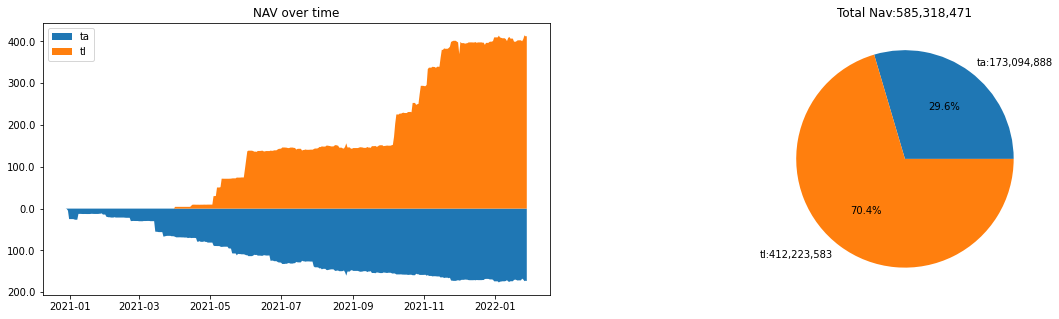

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2)  # type: ignore


# Line plot
for i, user_name in enumerate(user_name_l):
    sign = -1 if i % 2 == 0 else 1
    ax1.fill_between(log_df.index, sign * log_df[user_name], label=user_name)

# set labels to absolute values
ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))

ax1.set_title("NAV over time")
ax1.legend(loc="upper left")

# Pie chart
nav_l = [log_df[user_name].iloc[-1] for user_name in user_name_l]  # type: ignore
label_l = [f"{user_name}:{nav:,}" for user_name, nav in zip(user_name_l, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")


plt.show()


## [Chart] Index over time


/tmp/ipykernel_15684/1099213873.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
/tmp/ipykernel_15684/1099213873.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)


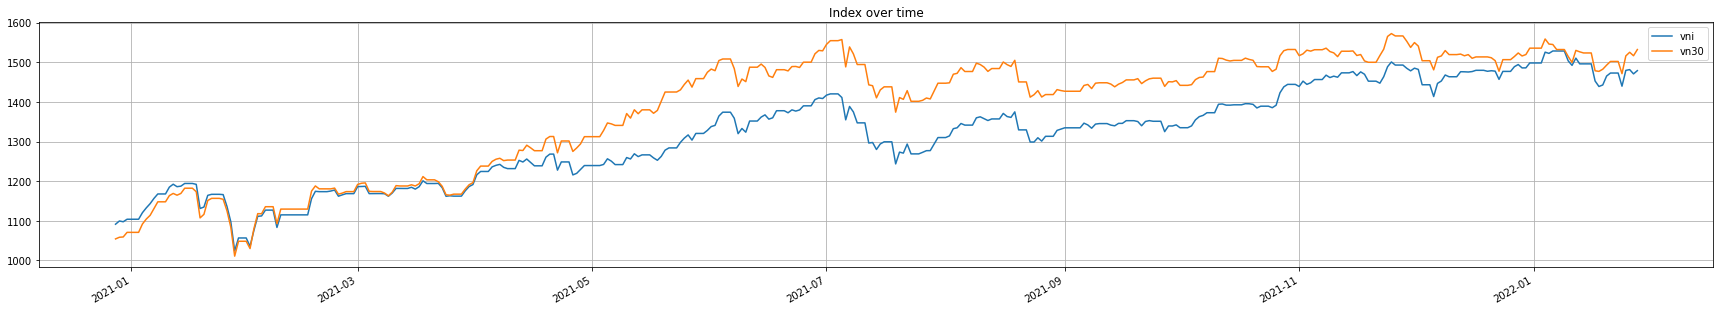

In [8]:
plt.figure(figsize=(30, 5))
plt.plot_date(log_df.index, log_df["vni"], label="vni", linestyle="-", marker=None)
plt.plot_date(log_df.index, log_df["vn30"], label="vn30", linestyle="-", marker=None)

plt.title("Index over time")

plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(True)

plt.show()


## [Process] Processing


### Adding diff columns


In [9]:
for name in user_name_l + index_name_l:
    log_df[f"{name}_diff"] = log_df[name].diff()
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-4152078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67


### Remove unchanged dates from `log_df`


In [10]:
unchanged_filt = log_df[f"{user_name_l[0]}_diff"] == 0
log_df = log_df.loc[~unchanged_filt]
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-4152078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,610408.0,324140.0,8.20,15.67


### Compensating diff with cashflow


In [11]:
for user_name in user_name_l:
    log_df[f"{user_name}_diff"] = log_df[f"{user_name}_diff"].add(
        cf_df[user_name], fill_value=0
    )
log_df.tail()

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67


### Adding Combined columns


In [12]:
# Diff for user
diff_user_column_name_l = [f"{user_name}_diff" for user_name in user_name_l]

log_df[user_combined] = log_df[user_name_l].sum(axis=1)
log_df[f"{user_combined}_diff"] = log_df[diff_user_column_name_l].sum(axis=1)

# Diff for index
diff_index_column_name_l = [f"{index_name}_diff" for index_name in index_name_l]

log_df[index_combined] = log_df[index_name_l].mean(axis=1)
log_df[f"{index_combined}_diff"] = log_df[diff_index_column_name_l].mean(axis=1)

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff
date,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935


### Calculating diff percent & aux diff percent


In [13]:
for name in user_name_combined_l + index_name_combined_l:

    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff"] / log_df[name].shift()

    # Replace inf values with nan in diff_p (otherwise, growth would be infinite)
    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff_p"].replace(
        [np.inf, -np.inf], np.nan
    )

    log_df[f"{name}_aux_diff_p"] = log_df[f"{name}_diff_p"] + 1

log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,0.977473,-0.020537,0.979463,-0.021522,0.978478
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,1.027693,0.030483,1.030483,0.029103,1.029103
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990


## [Chart] Diff percent


### Histogram

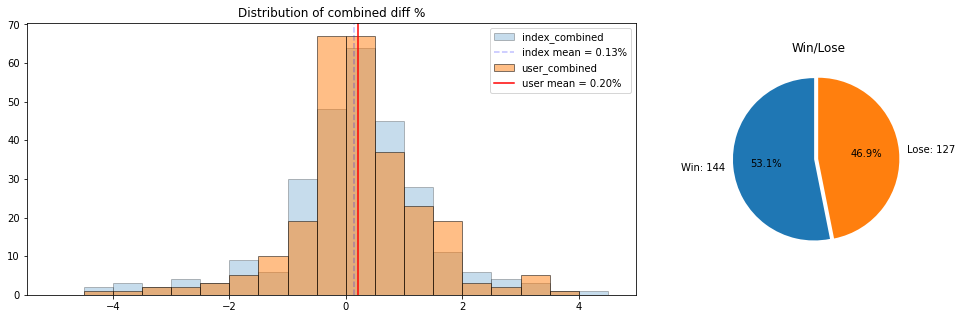

In [14]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
user_diff_p_l = log_df[f"{user_combined}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=index_combined,
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# User histogram
ax1.hist(
    user_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=user_combined,
)
user_diff_p_mean = user_diff_p_l.mean()  # type: ignore
ax1.axvline(
    user_diff_p_mean,
    color="red",
    label="user mean = %.2f%%" % user_diff_p_mean,
)


ax1.set_title("Distribution of combined diff %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (user_diff_p_l > index_diff_p_l).sum()
lose_num = (user_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


### Scatter plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


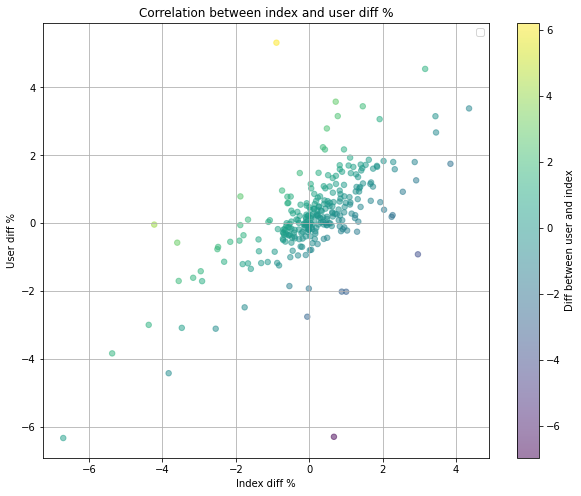

In [15]:
plt.figure(figsize=(10, 8))

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
user_diff_p_l = log_df[f"{user_combined}_diff_p"] * 100
plt.scatter(
    index_diff_p_l,
    user_diff_p_l,
    c=user_diff_p_l - index_diff_p_l,  # type: ignore
    s=30,
    alpha=0.5,
)

cbar = plt.colorbar()
cbar.set_label("Diff between user and index")

plt.title("Correlation between index and user diff %")
plt.xlabel("Index diff %")
plt.ylabel("User diff %")

plt.legend()
plt.grid(True)
plt.show()


## [Chart] Growth


In [16]:
log_df.iloc[-5:]

,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,0.977473,-0.020537,0.979463,-0.021522,0.978478
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,1.027693,0.030483,1.030483,0.029103,1.029103
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990


### Latest growth

/tmp/ipykernel_15684/1864263988.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1864263988.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1864263988.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1864263988.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1864263988.py:51: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-

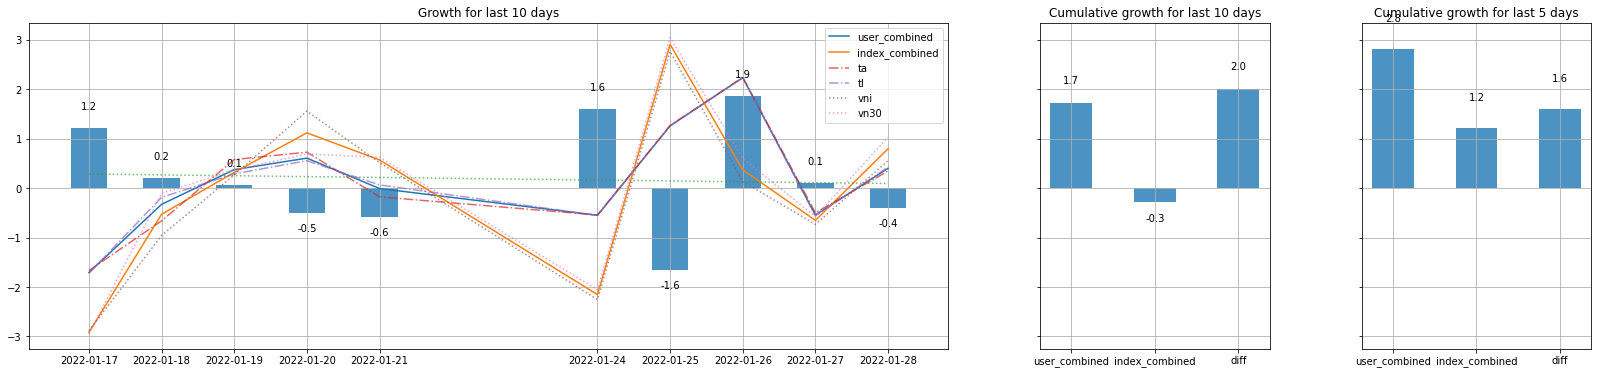

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(28, 6),
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [4, 1, 1]},
)  # type: ignore

# * Last x days line plot

last_10_days_df = log_df.iloc[-10:]

for combined_name in [user_combined, index_combined]:
    ax1.plot_date(
        last_10_days_df.index,
        last_10_days_df[f"{combined_name}_diff_p"] * 100,
        linestyle="-",
        marker=None,
        label=combined_name,
    )

last_10_days_diff = (
    last_10_days_df[f"{user_combined}_diff_p"]
    - last_10_days_df[f"{index_combined}_diff_p"]
) * 100

ax1.bar(
    last_10_days_df.index,
    last_10_days_diff,
    width=0.5,
    alpha=0.8,
)
add_labels(ax1, last_10_days_df.index, last_10_days_diff)

# Trendline
first_date = last_10_days_df.index[0]
x = [(date - first_date).days for date in last_10_days_df.index]
add_trend_line(ax1, ticks=last_10_days_df.index, x=x, y=last_10_days_diff)


for single_name in user_name_l:
    ax1.plot_date(
        last_10_days_df.index,
        last_10_days_df[f"{single_name}_diff_p"] * 100,
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        last_10_days_df.index,
        last_10_days_df[f"{single_name}_diff_p"] * 100,
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title("Growth for last 10 days")
ax1.set_xticks(ticks=last_10_days_df.index)
ax1.legend()
ax1.grid(True)


# * Cumulative growth bar plot
def _plot_cum_growth(df: pd.DataFrame, ax: plt.Axes, day_num: int) -> None:
    cum_user_growth = (df[f"{user_combined}_aux_diff_p"].product() - 1) * 100
    cum_index_growth = (df[f"{index_combined}_aux_diff_p"].product() - 1) * 100
    cum_diff_growth = cum_user_growth - cum_index_growth
    x = [user_combined, index_combined, "diff"]
    y = [cum_user_growth, cum_index_growth, cum_diff_growth]
    ax.bar(
        x,
        y,
        width=0.5,
        alpha=0.8,
    )
    ax.set_title(f"Cumulative growth for last {day_num} days")
    ax.grid(True)
    add_labels(ax, x, y)


_plot_cum_growth(last_10_days_df, ax2, 10)
_plot_cum_growth(last_10_days_df.iloc[-5:], ax3, 5)

plt.show()


### XIRR

2021-06-01 00:00:00
                     ta           tl  user_combined
2021-06-01 -111530258.0 -116254223.0   -227784481.0
2021-06-02          0.0  -20000000.0    -20000000.0
2021-06-22  -12000000.0          0.0    -12000000.0
2021-07-29  -10000000.0          0.0    -10000000.0
2021-08-20   -6000000.0          0.0     -6000000.0
2021-09-23    1500000.0          0.0      1500000.0
2021-10-06          0.0  -20000000.0    -20000000.0
2021-10-07          0.0  -30000000.0    -30000000.0
2021-10-08    1000000.0  -20000000.0    -19000000.0
2021-10-22          0.0  -20000000.0    -20000000.0
2021-10-25     550000.0          0.0       550000.0
2021-10-28          0.0  -20000000.0    -20000000.0
2021-10-29          0.0  -20000000.0    -20000000.0
2021-11-04          0.0  -40000000.0    -40000000.0
2021-11-15   -1900000.0  -20000000.0    -21900000.0
2021-11-16          0.0  -20000000.0    -20000000.0
2021-11-23    2200000.0          0.0      2200000.0
2021-11-24   -1150000.0          0.0     -11

/tmp/ipykernel_15684/1989219115.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1989219115.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1989219115.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1989219115.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/tmp/ipykernel_15684/1989219115.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-

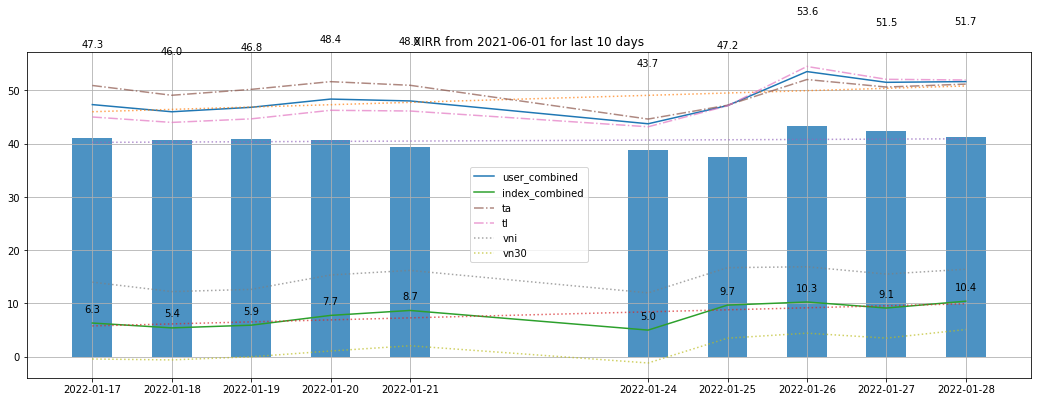

In [44]:
anchor_date = '2021-06-01'

xirr_data = {name:[] for name in user_name_combined_l+ index_name_combined_l}
for idx in log_df.index[-10:]:
    for name in user_name_combined_l:
        xirr_data[name].append(_calc_cashflow_xirr(cf_df, log_df,anchor_date, idx, name))
    for idx_name in index_name_combined_l:
        xirr_data[idx_name].append(_calc_index_xirr(log_df, anchor_date, idx, idx_name))
xirr_df = pd.DataFrame(xirr_data, index=log_df.index[-10:])


fig, ax1 = plt.subplots(figsize=(18, 6))  # type: ignore

# * Last x days line plot

for combined_name in [user_combined, index_combined]:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[combined_name] * 100, # type: ignore
        linestyle="-",
        marker=None,
        label=combined_name,
    )
    add_labels(ax1, xirr_df.index, xirr_df[combined_name] * 100) # type: ignore

    # Trendline
    first_date = xirr_df.index[0]
    x = [(date - first_date).days for date in xirr_df.index]
    add_trend_line(ax1, ticks=xirr_df.index, x=x, y=xirr_df[combined_name] * 100) # type: ignore

last_x_days_diff = (xirr_df[user_combined] - xirr_df[index_combined]) * 100 # type: ignore

ax1.bar(
    xirr_df.index,
    last_x_days_diff,
    width=0.5,
    alpha=0.8,
)
# Trendline
first_date = xirr_df.index[0]
x = [(date - first_date).days for date in xirr_df.index]
add_trend_line(ax1, ticks=xirr_df.index, x=x, y=last_x_days_diff) # type: ignore



for single_name in user_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100, # type: ignore
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100, # type: ignore
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title(f"XIRR from {anchor_date} for last 10 days")
ax1.set_xticks(ticks=xirr_df.index)
ax1.legend()
ax1.grid(True)

plt.show()


In [41]:
xirr_df

,ta,tl,user_combined,vni,vn30,index_combined
date,,,,,,
2022-01-17,0.509411,0.450206,0.473473,0.139897,-0.004608,0.063023
2022-01-18,0.491014,0.440002,0.460021,0.122076,-0.006237,0.053905
2022-01-19,0.502055,0.446686,0.468385,0.126244,-0.000393,0.058981
2022-01-20,0.516617,0.462772,0.483863,0.153303,0.010467,0.077359
2022-01-21,0.509799,0.461444,0.480364,0.161926,0.020311,0.086652
2022-01-24,0.446298,0.431809,0.437459,0.119731,-0.012032,0.049738
2022-01-25,0.472305,0.471185,0.471623,0.167082,0.034581,0.096730
2022-01-26,0.520598,0.545137,0.535518,0.168736,0.043983,0.102544
2022-01-27,0.506480,0.521001,0.515327,0.155030,0.034714,0.091211


### Growth time series


In [20]:
def get_overall_growth_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    log_df = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=log_df.index)
    for name in user_name_combined_l + index_name_combined_l:
        # set first date aux_diff_p to 1
        log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
        # calculate growth using cumulative product since anchor date
        df[name] = log_df[f"{name}_aux_diff_p"].cumprod()
    return df.fillna(1)  # type: ignore


/tmp/ipykernel_15684/1348175528.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/tmp/ipykernel_15684/1348175528.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/tmp/ipykernel_15684/1348175528.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/tmp/ipykernel_1

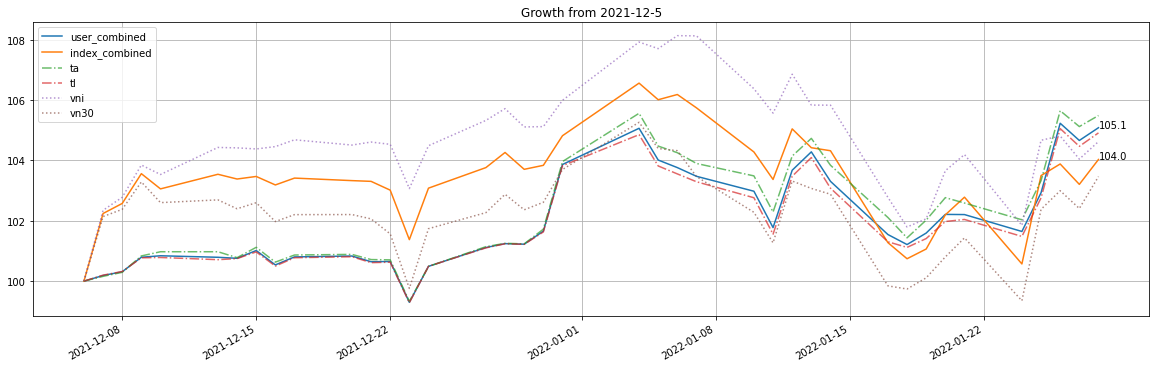

In [21]:
fig, ax = plt.subplots(figsize=(20, 6))

anchor_date = "2021-12-5"
growth_df = get_overall_growth_df(log_df, anchor_date=anchor_date)

growth_df = growth_df.applymap(lambda x: x * 100)

for combined_name in [user_combined, index_combined]:
    ax.plot_date(
        growth_df.index,
        growth_df[combined_name],
        linestyle="-",
        marker=None,
        label=combined_name,
    )
    ax.text(
        growth_df.index[-1],
        growth_df[combined_name].iloc[-1],
        f"{growth_df[combined_name].iloc[-1]:.1f}",
    )

for single_name in user_name_l:
    ax.plot_date(
        growth_df.index,
        growth_df[single_name],
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax.plot_date(
        growth_df.index,
        growth_df[single_name],
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax.set_title(f"Growth from {anchor_date}")
ax.legend()
ax.grid(True)
fig.autofmt_xdate()


plt.show()


## [Process] Add period info


In [22]:
log_df["Y"] = log_df.index.to_period("Y")  # type: ignore
log_df["Q"] = log_df.index.to_period("Q")  # type: ignore
log_df["M"] = log_df.index.to_period("M")  # type: ignore
log_df.tail()


,ta,tl,vni,vn30,ta_diff,tl_diff,vni_diff,vn30_diff,user_combined,user_combined_diff,index_combined,index_combined_diff,ta_diff_p,ta_aux_diff_p,tl_diff_p,tl_aux_diff_p,user_combined_diff_p,user_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p,Y,Q,M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-24,167416073,400128653,1439.71,1471.31,-928078.0,-2217055.0,-33.18,-30.85,567544726,-3145133.0,1455.510,-32.015,-0.005409,0.994591,-0.005510,0.994490,-0.005480,0.994520,-0.022527,0.977473,-0.020537,0.979463,-0.021522,0.978478,2022,2022Q1,2022-01
2022-01-25,169543555,405165142,1479.58,1516.16,2127482.0,5036489.0,39.87,44.85,574708697,7163971.0,1497.870,42.360,0.012708,1.012708,0.012587,1.012587,0.012623,1.012623,0.027693,1.027693,0.030483,1.030483,0.029103,1.029103,2022,2022Q1,2022-01
2022-01-26,173345446,414219519,1481.58,1525.31,3801891.0,9054377.0,2.00,9.15,587564965,12856268.0,1503.445,5.575,0.022424,1.022424,0.022347,1.022347,0.022370,1.022370,0.001352,1.001352,0.006035,1.006035,0.003722,1.003722,2022,2022Q1,2022-01
2022-01-27,172484480,411899443,1470.76,1516.57,-860966.0,-2320076.0,-10.82,-8.74,584383923,-3181042.0,1493.665,-9.780,-0.004967,0.995033,-0.005601,0.994399,-0.005414,0.994586,-0.007303,0.992697,-0.005730,0.994270,-0.006505,0.993495,2022,2022Q1,2022-01
2022-01-28,173094888,412223583,1478.96,1532.24,600287.0,1758140.0,8.20,15.67,585318471,2358427.0,1505.600,11.935,0.003480,1.003480,0.004268,1.004268,0.004036,1.004036,0.005575,1.005575,0.010333,1.010333,0.007990,1.007990,2022,2022Q1,2022-01


In [23]:
def get_period_df(period_symbol, log_df):
    period_l = log_df[period_symbol].unique()

    data = []
    for period in period_l:
        period_data_dict = {"period": period}
        period_filt = log_df[period_symbol] == period
        period_df = log_df.loc[period_filt]

        for user_name in user_name_combined_l + index_name_combined_l:
            period_growth = period_df[f"{user_name}_aux_diff_p"].product()  # type: ignore
            period_data_dict[f"{user_name}_growth"] = (period_growth - 1) * 100  # type: ignore

        data.append(period_data_dict)

    period_df = pd.DataFrame(data)
    period_df = period_df.set_index("period")
    period_df.index = period_df.index.to_series().astype(str)
    return period_df


## [Chart] Monthly


In [24]:
monthly_df = get_period_df("M", log_df)
monthly_df


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2020-12,-1.208601,0.000000,-1.208601,1.149057,1.568918,1.355357
2021-01,-5.801495,0.000000,-5.801495,-4.281301,-2.097556,-3.206048
2021-02,11.919800,0.000000,11.919800,10.586688,11.951617,11.266461
2021-03,2.130464,0.000000,2.130464,1.965819,1.929107,1.947423
2021-04,9.782790,0.567937,9.265127,4.024542,9.700395,6.868173
2021-05,9.143898,11.870611,9.742956,7.153519,12.383028,9.842966
2021-06,5.797309,6.513758,6.157616,6.061519,3.676481,4.806571
2021-07,1.017875,0.402725,0.706302,-6.993007,-5.347940,-6.136747
2021-08,0.864777,-0.264489,0.295285,1.635052,-1.283141,0.103363


In [25]:
def plot_growth(growth_df: pd.DataFrame, period_name: str):

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 6))  # type: ignore

    # *** AX1 ***

    # * Draw bar chart

    x_indices = np.arange(len(growth_df.index))

    bar_name_l = user_name_l + index_name_l
    bar_count = len(bar_name_l)
    total_width = 0.6
    bar_width = total_width / bar_count

    for i, name in enumerate(bar_name_l):
        position = x_indices + i * bar_width
        ax1.bar(
            position,
            growth_df[f"{name}_growth"],
            label=name,
            width=bar_width,
        )

    # move back half bar width to left most edge and then move to the middle of the bar group
    ticks = x_indices - (0.5 * bar_width) + (bar_count / 2 * bar_width)

    # * Draw line chart

    for name in [user_combined, index_combined]:
        ax1.plot(
            ticks,
            growth_df[f"{name}_growth"],
            label=name,
            linestyle="--",
        )

    ax1.fill_between(
        ticks,
        growth_df[f"{user_combined}_growth"],
        growth_df[f"{index_combined}_growth"],
        where=(
            growth_df[f"{user_combined}_growth"]
            >= growth_df[f"{index_combined}_growth"]  # type: ignore
        ),
        color="green",
        interpolate=True,
        alpha=0.25,
    )

    ax1.fill_between(
        ticks,
        growth_df[f"{user_combined}_growth"],
        growth_df[f"{index_combined}_growth"],
        where=(
            growth_df[f"{user_combined}_growth"] < growth_df[f"{index_combined}_growth"]  # type: ignore
        ),
        color="red",
        interpolate=True,
        alpha=0.25,
    )

    # * Decorations

    ax1.set_xticks(
        ticks=ticks,
        labels=growth_df.index,
        rotation=90,
    )

    ax1.set_title(f"{period_name} growth")
    ax1.set_ylabel("Growth %")
    ax1.legend()

    ax1.grid(True)

    # *** AX2 ***
    # Diff bar
    diff_series = (
        growth_df[f"{user_combined}_growth"] - growth_df[f"{index_combined}_growth"]  # type: ignore
    )
    ax2.bar(
        ticks,
        diff_series,
        width=bar_width,
        label="Diff (user - index)",
    )
    add_labels(ax2, ticks, diff_series)

    add_trend_line(ax2, ticks, ticks, diff_series)

    # Growth line
    for name in [user_combined, index_combined]:
        ax2.plot(
            ticks,
            growth_df[f"{name}_growth"],
            label=name,
            marker="o",
            linestyle="-",
        )

    ax2.set_title("Diff In Growth")
    ax2.set_xlabel(period_name)
    ax2.set_ylabel("Growth %")
    ax2.legend()
    ax2.grid(True)

    plt.show()


In [26]:
monthly_df = get_period_df("M", log_df)
monthly_df.head()


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2020-12,-1.208601,0.000000,-1.208601,1.149057,1.568918,1.355357
2021-01,-5.801495,0.000000,-5.801495,-4.281301,-2.097556,-3.206048
2021-02,11.919800,0.000000,11.919800,10.586688,11.951617,11.266461
2021-03,2.130464,0.000000,2.130464,1.965819,1.929107,1.947423
2021-04,9.782790,0.567937,9.265127,4.024542,9.700395,6.868173


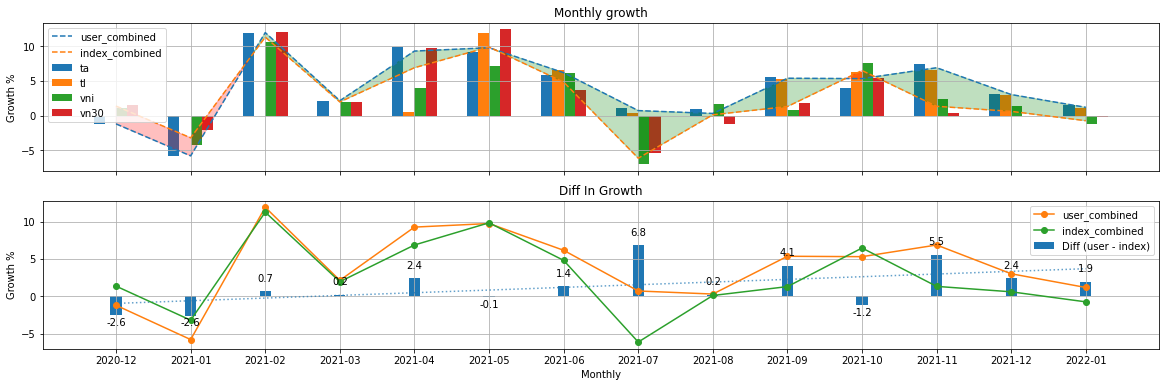

In [27]:
plot_growth(monthly_df, "Monthly")


## Quaterly


In [28]:
quaterly_df = get_period_df("Q", log_df)
quaterly_df.tail()


,ta_growth,tl_growth,user_combined_growth,vni_growth,vn30_growth,index_combined_growth
period,,,,,,
2021Q1,7.672858,0.000000,7.672858,7.932999,11.717736,9.796564
2021Q2,26.767623,19.834332,27.294426,18.222487,27.817160,23.029468
2021Q3,7.489684,5.362412,6.414699,-4.720457,-4.920863,-4.824769
2021Q4,15.080954,16.638849,15.924224,11.640314,5.637107,8.518789
2022Q1,1.467287,1.048883,1.173594,-1.289479,-0.225954,-0.751156


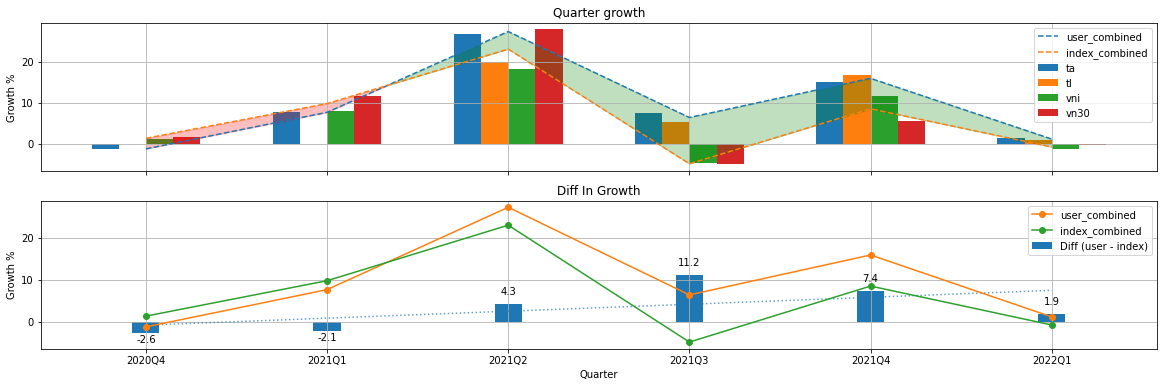

In [29]:
plot_growth(quaterly_df, "Quarter")
